# <center> Neural Network Architectures for Sequential Data: Convolutional vs Recursive </center>
### <center> Application : entity recognition in research articles for scientific monitoring on microbiota</center>



# Note
The modeling part is fast to run because we worked on a sample of the full dataset. If you want to **run the modeling part only** you just have to:
1. Run the [prerequisites](#prerequisites) part 
2. Then run the [modeling](#modeling) part

## 1 [Goals of the project](#goals)
## 2 [Prerequisites ](#prerequisites )
### &emsp; 2.1 [Requirements](#requirements)
### &emsp; 2.2 [Imports](#imports)

## 3 [Dataset building](#dataset_building)
### &emsp;3.1 [Microbiological datasets review](#microbio_datasets)
#### &emsp;&emsp;3.1.1 [GutMDisorder (GMD)](#gmd)
#### &emsp;&emsp;3.1.2 [PubMed (PM) and PubMed Central (PMC)](#pmc)
#### &emsp;&emsp;3.1.3 [Steps to build the working dataset](#steps_data_building)
### &emsp;3.2 [Batch download of PMC articles](#download_pmc)
#### &emsp;&emsp;3.2.1 [Methodology](#download_method)
#### &emsp;&emsp;3.2.2 [Scraping of GDM dataset and PMC IDs](#scraping)  
#### &emsp;&emsp;3.2.3 [Get PMCID from PMID](#pmcid_from_pmid)
#### &emsp;&emsp;3.2.4 [Download articles from PMC API](#download_articles)
### &emsp;3.3 [OCR and data modeling](#ocerize_articles)
## 4 [Modeling](#modeling)
### &emsp;4.1 [Data preparation](#data_prep)
#### &emsp;&emsp;4.1.1 [Computing of the target](#target_computing)
#### &emsp;&emsp;4.1.2 [Text preprocessing](#text_preprocessing)
### &emsp; 4.2 [A recurrent network: LSTM](#lstm)
### &emsp; 4.3 [A convolutionnal network](#cnn)
## 5 [Conclusion](#conclusion)

## 1 Goals of the project <a name="goals"></a>

As part of the 3rd year Deep Learning course at ENSAE, we propose to build neural architectures to solve a specific problem.

We have chosen the theme of convolutional and recursive architectures for sequential data, which corresponds to one of the 3 directions proposed by the teacher (see https://marcocuturi.net/dl.html).

We chose this theme because it seemed to us to group together the most applications likely to respond to a concrete problem for a given sector.

Indeed, convolutional (CNNs) and recursive (RvNNs) neural networks are renowned for their performance in the fields of Optical Character Recognition (OCR) and Natual Language Processing (NLP).

Moreover, textual data - whether handwritten, dictalographed, scanned or digitally encoded - are sequential and are present in multiple documents of different natures, which lets us imagine a large number of concrete applications in many sectors. We have chosen to focus on the field of healthcare, currently abounding in terms of written publications given the health crisis situation.

The final objective is to build a **monitoring system on microbiota**. This system should be able to extract all microbiota bacteria contained in a given research article, as well as a number of additional features like the paper title, authors, or the classification type of the micrcobiota (family, genus, ...). 
To do this, we will firstly build the dataset. Then, we will distinguish 2 main stages which we will use as a pretext to meet the requirements of this project:
- Text recognition by OCR
- Text classification 

This notebook is designed to be both executed on Google Colab or locally on a Windows OS. The full project and code is available at https://gitlab.com/Baartur/dl-ocr-nlp-cnn-rvnn. Many efforts have been attributed to the packaging of the project.

# 2 Prerequisites <a name="prerequisites"></a>

### &emsp;2.1 Requirements <a name="requirements"></a>

Are you working on Google Colab?

In [ ]:
if 'google.colab' in str(get_ipython()):
    IS_ON_COLAB = True
else:
    IS_ON_COLAB = False

In [ ]:
IS_ON_COLAB

True

If you are not on Colab we suggest you to download the [git repository](#https://gitlab.com/Baartur/dl-ocr-nlp-cnn-rvnn) and to work on the notebook <code>DL_project_B_ARTUR.ipynb</code> that you will find in the folder <code>notebooks</code>.

Download project and install simple requirements via pip:

In [ ]:
if IS_ON_COLAB:
    !wget https://gitlab.com/Baartur/dl-ocr-nlp-cnn-rvnn/-/archive/master/dl-ocr-nlp-cnn-rvnn-master.zip
    !unzip /content/dl-ocr-nlp-cnn-rvnn-master.zip
    !pip install -r '/content/dl-ocr-nlp-cnn-rvnn-master/requirements.txt'
    !apt-get install libmagickwand-dev #Download Wand for image conversion
    !pip install tesseract #Intall pytesseract

--2021-04-29 23:52:11--  https://gitlab.com/Baartur/dl-ocr-nlp-cnn-rvnn/-/archive/master/dl-ocr-nlp-cnn-rvnn-master.zip
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘dl-ocr-nlp-cnn-rvnn-master.zip’

dl-ocr-nlp-cnn-rvnn     [  <=>               ]   5.20M  8.08MB/s    in 0.6s    

2021-04-29 23:52:12 (8.08 MB/s) - ‘dl-ocr-nlp-cnn-rvnn-master.zip’ saved [5451139]

Archive:  /content/dl-ocr-nlp-cnn-rvnn-master.zip
2f49370634adcd331c72ffef94c671b5d84763eb
   creating: dl-ocr-nlp-cnn-rvnn-master/
  inflating: dl-ocr-nlp-cnn-rvnn-master/.gitignore  
  inflating: dl-ocr-nlp-cnn-rvnn-master/README.md  
   creating: dl-ocr-nlp-cnn-rvnn-master/data/
 extracting: dl-ocr-nlp-cnn-rvnn-master/data/.gitkeep  
   creating: dl-ocr-nlp-cnn-rvnn-master/data/processed/
 extracting: dl-ocr-nlp-cnn-rvnn

**If code is executed locally under Windows OS, install Tesseract:**
 
&emsp;&emsp; 1. Download and execute Windows installer available here: https://github.com/UB-Mannheim/tesseract/wiki \
&emsp;&emsp; 2. Note the installation path into <code>custom_tess_path</code> below \
&emsp;&emsp; 3. Run <code>pip intall pytesseract</code>

In [ ]:
if not IS_ON_COLAB:
    from pathlib import Path
    custom_tess_path = Path('C:/Program Files/Tesseract-OCR/tesseract.exe')

### &emsp;2.2 Imports <a name="imports"></a>

Import all the required packages:

In [ ]:
# System imports 
import os, sys

# Insert path to project to sys path
if 'google.colab' in str(get_ipython()):
    IS_ON_COLAB = True
    sys.path.insert(0, "/content/dl-ocr-nlp-cnn-rvnn-master/src")
else:
    IS_ON_COLAB = False
    sys.path.insert(0, "../src")

# Common imports
import pandas as pd
import numpy as np
import wget, requests, tarfile, gzip, shutil, ntpath
from xml.etree import ElementTree
from pathlib import Path
from os.path import join
from importlib import reload
from shutil import copyfile
from sklearn.model_selection import train_test_split

# Deep Learning imports
import torch, torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils import weight_norm

# NLP imports
import re

# Viz
import matplotlib.pyplot as plt
import seaborn as sns 
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report

# For OCR
import pytesseract as pyt
import cv2
from tesseract2dict import TessToDict
td=TessToDict()

# Personal modules
import ocr, imtools, settings, data
import settings.paths, settings.utils, settings.params
reload(ocr), reload(imtools), reload(settings.paths), reload(settings.utils), reload(settings.params)
from ocr import ImageOCR, PdfOCR
from imtools import PdfToImage
from settings.utils import optim_copyfile
from settings.paths import DATA_DIR, NCBI_DATA_DIR, GMD_DATA_DIR, ARTICLES_DATA_DIR, PDFS_DATA_DIR
from settings.paths import RAW_DATA_DIR, UNZIPS_DATA_DIR, PROCESSED_DATA_DIR, OCRIZED_DATA_DIR
from settings.paths import TESSERACT_EXE_PATH
from settings.params import IS_ON_COLAB, LABELS
from data.collect import unzip_pmc_folder

# Options
torch.manual_seed(1)
tqdm.pandas()
pd.options.mode.chained_assignment = None 

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Set the proper path pointing to the executable Tesseract file:

In [ ]:
if IS_ON_COLAB:
    TESS_PATH = Path(r'/usr/local/bin/pytesseract')
elif not 'custom_tess_path' in locals():
    TESS_PATH = TESSERACT_EXE_PATH
else:
    TESS_PATH = custom_tess_path

## 3 Dataset building <a name="dataset_building"></a>

### &emsp;3.1 Microbiological datasets review <a name="microbio_datasets"></a>
We first discovered the existence of a free access database specific to the microbiota and documented in [[3]](#gmd_paper). We thought that this retreated database could be a good basis to construct our labels in a supervised setting. We had from [[2]](#db_for_microbio) a good overview of open data in microbilogy, which showed us the diversity of microbiology opendata, with one of the major actor: NCBI and its databases PubMed and PubMed Central.

#### &emsp;&emsp;3.1.1 GutMDisorder (GMD) <a name="gmd"></a>
GMD is a database that lists the knowned associations between gut microbiota and disorders or interventions in Human and Mouse. We focused on the Human dataset.

The associations are proved in papers. These papers are the index of the GMD database. The data contained in GMD are extracted manually and we will use it to label our dataset.

GMD database contains PubMed ids so we will explain below what it is.

#### &emsp;&emsp;3.1.2 PubMed (PM) and PubMed Central (PMC) <a name="pmc"></a>
PubMed Central (PMC) is an electronic archive of **full-text journal articles**, offering **free access** to its contents. It was developed and is operated by the National Center for Biotechnology Information (NCBI), a division of the National Library of Medicine (NLM) at the U.S. National Institutes of Health (NIH).

PubMed Central is a free digital archive of full articles, accessible to anyone from anywhere via a web browser (with varying provisions for reuse). PMC is distinct from PubMed, which is a database of citations and abstracts. Although PubMed is a searchable database of biomedical citations and abstracts, the full-text article resides elsewhere (in print or online, free or behind a subscriber paywall). 

PMC provides a web service, called [OA Web Service](https://www.ncbi.nlm.nih.gov/pmc/tools/oa-service/), that we can request to get the link of the articles, or projects containing an article, we would like to download.

#### &emsp;&emsp;3.1.3 Steps to build the working dataset <a name="steps_data_building"></a>
We set the following pipeline to construct the database:

**1. Download GMD dataset \
2. Download free access articles contained in GMD by requesting [OA Web Service](https://www.ncbi.nlm.nih.gov/pmc/tools/oa-service/) \
3. Ocerize each article downloaded \
4. Match the result of the OCR with GMD dataset to obtain the labelled dataset**

### &emsp;3.2 Batch download of PMC articles <a name="download_pmc"></a>

#### &emsp;&emsp;3.2.1 Methodology <a name="download_method"></a>
As explained in the open data review for microbiology, articles of PubMed are not always in free access. Therefore, we will work on the free access articles from PMC. 

Thus, we set the following pipeline to download the articles:

**1. Scrap GMD data <code>human.xlsx</code> and the correspondance table <code>PMC-ids.csv</code> between PubMed id <code>PMID</code> and PMC id <code>PMCID</code> \
2. For each <code>PMID</code> in GMD, search for the corresponding <code>PMCID</code> when it exists in PMC-ids file \
3. Request [OA Web Service](https://www.ncbi.nlm.nih.gov/pmc/tools/oa-service/) to get the link to each article project \
4. Download the file to which this link point and save it in <code>RAW_DATA_DIR</code> \
5. Process this file to find the article in PDF format and save it in <code>PDFS_DATA_DIR</code>**

#### &emsp;&emsp;3.2.2 Scraping of GMD dataset and PMC IDs <a name="scraping"></a>

Scrap GMD data <code>human.xlsx</code> and the correspondance table <code>PMC-ids.csv</code>.

In [ ]:
if IS_ON_COLAB:
    # Download human dataset of gutMDisorder database (denoted as GMD below)
    !wget -P /content/dl-ocr-nlp-cnn-rvnn-master/data/gutMDisorder http://bio-annotation.cn/gutMDisorder/public/res/human.xlsx
        
    # Get PubMed Central (PMC) ids 
    !wget -P /content/dl-ocr-nlp-cnn-rvnn-master/data/NCBI https://ftp.ncbi.nlm.nih.gov/pub/pmc/PMC-ids.csv.gz
else:
    # Download human dataset of gutMDisorder database (denoted as GMD below)
    url_gmd = "http://bio-annotation.cn/gutMDisorder/public/res/human.xlsx"
    filename = wget.download(url_gmd, out=GMD_DATA_DIR.as_posix())
    
    # Get PubMed Central (PMC) ids 
    url = "https://ftp.ncbi.nlm.nih.gov/pub/pmc/PMC-ids.csv.gz"
    filename = wget.download(url, out=NCBI_DATA_DIR.as_posix())

In [ ]:
# Unzip the CSV file

fname_in = os.path.join(NCBI_DATA_DIR,'PMC-ids.csv.gz')
fname_out = os.path.join(NCBI_DATA_DIR,'PMC-ids.csv')
with gzip.open(fname_in, 'rb') as f_in:
    with open(fname_out, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

#### &emsp;&emsp;3.2.3 Get PMCID from PMID <a name="pmcid_from_pmid"></a>

In [ ]:
# Read IDs file
df_ids = pd.read_csv(join(NCBI_DATA_DIR,'PMC-ids.csv'), low_memory=False)

In [ ]:
# Read GMD file
df_human = pd.read_excel(join(GMD_DATA_DIR,'human.xlsx'))

In [ ]:
# Merge GMD data with IDs on PMID
df_merge = pd.merge(left=df_human, right=df_ids, how='inner', on='PMID')

In [ ]:
df_merge

Index      PMID                Journal  \
0        4  29335008             Microbiome   
1        5  29329346               PLoS One   
2        6  29323208     Scientific Reports   
3        7  29321519  NATURE COMMUNICATIONS   
4       10  29232848              Nutrients   
..     ...       ...                    ...   
184    319  28362071         J Int AIDS Soc   
185    321  28328990               PLoS One   
186    323  28279152          BMC Microbiol   
187    324  28274256             Microbiome   
188    325  28245856             Genome Med   

                                                 Title  \
0    Multi-omics differentially classify disease st...   
1    Evaluation of bloodstream infections, Clostrid...   
2    Composition of salivary microbiota in elderly ...   
3    Maturation of the gut microbiome and risk of a...   
4    A Metagenomic and in Silico Functional Predict...   
..                                                 ...   
184  Differential effects of antiretrovirals on mic...   
185  Gut microbiome analysis of type 2 diabetic pat...   
186  The altered gut microbiota in adults with cyst...   
187  Intestinal dysbiosis in preterm infants preced...   
188  Characterization of oral and gut microbiome te...   

                                               Authors  \
0    Douglas GM, Hansen R, Jones CMA, Dunn KA, Come...   
1    Nycz BT, Dominguez SR, Friedman D, Hilden JM, ...   
2    Ogawa T, Hirose Y, Honda-Ogawa M, Sugimoto M, ...   
3    Stokholm J, Blaser MJ, Thorsen J, Rasmussen MA...   
4    Vernocchi P, Del Chierico F, Quagliariello A, ...   
..                                                 ...   
184  Villanueva-Millán MJ, Pérez-Matute P, Recio-Fe...   
185  Wang Y, Luo X, Mao X, Tao Y, Ran X, Zhao H, Xi...   
186  Burke DG, Fouhy F, Harrison MJ, Rea MC, Cotter...   
187  Pammi M, Cope J, Tarr PI, Warner BB, Morrow AL...   
188  Galloway-Peña JR, Smith DP, Sahasrabhojane P, ...   

                                         Research Type         Intervention  \
0              Gut microbiota associated with disorder                  NaN   
1              Gut microbiota associated with disorder                  NaN   
2              Gut microbiota associated with disorder                  NaN   
3              Gut microbiota associated with disorder                  NaN   
4              Gut microbiota associated with disorder                  NaN   
..                                                 ...                  ...   
184  Interventions change the composition of gut mi...  antiretroviral drug   
185            Gut microbiota associated with disorder                  NaN   
186            Gut microbiota associated with disorder                  NaN   
187            Gut microbiota associated with disorder                  NaN   
188            Gut microbiota associated with disorder                  NaN   

    Intervention Type Intervention ID  \
0                 NaN             NaN   
1                 NaN             NaN   
2                 NaN             NaN   
3                 NaN             NaN   
4                 NaN             NaN   
..                ...             ...   
184              Drug             NaN   
185               NaN             NaN   
186               NaN             NaN   
187               NaN             NaN   
188               NaN             NaN   

                                         Disorder Name  ... ISSN      eISSN  \
0                                      Crohn's disease  ...  NaN  2049-2618   
1    bloodstream infections in pediatric oncology  ...  ...  NaN  1932-6203   
2                                        frail elderly  ...  NaN  2045-2322   
3                                               asthma  ...  NaN  2041-1723   
4                                      cystic fibrosis  ...  NaN  2072-6643   
..                                                 ...  ...  ...        ...   
184    human immunodeficiency virus infectious dise

In [ ]:
df_ids_short = df_merge[["PMID", "PMCID"]].drop_duplicates()
df_ids_short

PMID       PMCID
0    29335008  PMC5769311
1    29329346  PMC5766145
2    29323208  PMC5765146
3    29321519  PMC5762761
4    29232848  PMC5748792
..        ...         ...
184  28362071  PMC5467634
185  28328990  PMC5362050
186  28279152  PMC5345154
187  28274256  PMC5343300
188  28245856  PMC5331640

[149 rows x 2 columns]

In [ ]:
df_ids_short.to_csv(join(NCBI_DATA_DIR, "PMID_to_PMCID.csv"), sep=";", index=False)

#### &emsp;&emsp;3.2.4 Download articles from PMC API <a name="download_articles"></a>

In [ ]:
len(df_merge.PMCID.iloc[0:].unique())

149

In [ ]:
pdf_list = []
not_open_pdf_list = []
for pmcid in df_merge.PMCID.iloc[0:].unique():
    print("PMCID:", pmcid)
    # Request OA web service to get links associated with these PMCID
    links_list = get_links_from_PMCID(pmcid)
    
    # Keep maximum one link per PMCID
    if links_list:
        pdf_link = keep_one_link(pmcid=pmcid, list_of_links=links_list, ext_pref='pdf')


        # Donwload content from selected link (if not already downloaded)
        fname = ntpath.basename(pdf_link)
        fpath = os.path.join(RAW_DATA_DIR, fname)
        new_fpath = os.path.join(PDFS_DATA_DIR, pmcid+".pdf")
        if not os.path.exists(fpath):
            wget.download(pdf_link, out=RAW_DATA_DIR)
            print()#add a line break


        if not fname.endswith(".pdf"):
            message = f"Unzip {fname} to {UNZIPS_DATA_DIR}"
            folder_path, folder_name = unzip_pmc_folder(fpath=fpath, message_if_extraction=message)
#             folder_path = os.path.join(ARTICLES_DATA_DIR, folder_name)
            article_to_copy = find_article_in_folder(folder_path)
            
            if article_to_copy!=None:
#                 new_article_path = os.path.join(PDFS_DATA_DIR, pmcid)
                if not os.path.exists(new_fpath):
                    print(f"Copy {article_to_copy} to {PDFS_DATA_DIR}")
                    shutil.copyfile(os.path.join(folder_path, article_to_copy), new_fpath)

        else:
            shutil.copyfile(fpath, new_fpath)
    else:
        print(f"{pmcid} doesn' seem to be Open Access")
        not_open_pdf_list.append(pmcid)
        
    print() #add a line break

PMCID: PMC5769311
100% [..........................................................................] 3476225 / 3476225
Unzip PMC5769311.tar.gz to C:\Users\Baptiste ARTUR\Files\Scolaire\ENSAE\Cours 3A\S2\Deep-Learning\Projet\Use-Case-Healthcare\data\articles\unzips
Copy 40168_2018_Article_398.pdf to C:\Users\Baptiste ARTUR\Files\Scolaire\ENSAE\Cours 3A\S2\Deep-Learning\Projet\Use-Case-Healthcare\data\articles\pdfs

PMCID: PMC5766145
100% [..........................................................................] 4561003 / 4561003
Unzip PMC5766145.tar.gz to C:\Users\Baptiste ARTUR\Files\Scolaire\ENSAE\Cours 3A\S2\Deep-Learning\Projet\Use-Case-Healthcare\data\articles\unzips
No clear article name found in folder PMC5766145.tar.gz, first PDF file found pone.0191232.pdf is therefore considered as an article
Copy pone.0191232.pdf to C:\Users\Baptiste ARTUR\Files\Scolaire\ENSAE\Cours 3A\S2\Deep-Learning\Projet\Use-Case-Healthcare\data\articles\pdfs

PMCID: PMC5765146
100% [...................

100% [..........................................................................] 3282244 / 3282244
Unzip PMC6037668.tar.gz to C:\Users\Baptiste ARTUR\Files\Scolaire\ENSAE\Cours 3A\S2\Deep-Learning\Projet\Use-Case-Healthcare\data\articles\unzips
Copy 41467_2018_Article_5184.pdf to C:\Users\Baptiste ARTUR\Files\Scolaire\ENSAE\Cours 3A\S2\Deep-Learning\Projet\Use-Case-Healthcare\data\articles\pdfs

PMCID: PMC3386193
100% [..........................................................................] 6103690 / 6103690
Unzip PMC3386193.tar.gz to C:\Users\Baptiste ARTUR\Files\Scolaire\ENSAE\Cours 3A\S2\Deep-Learning\Projet\Use-Case-Healthcare\data\articles\unzips
No clear article name found in folder PMC3386193.tar.gz, first PDF file found pone.0039743.pdf is therefore considered as an article
Copy pone.0039743.pdf to C:\Users\Baptiste ARTUR\Files\Scolaire\ENSAE\Cours 3A\S2\Deep-Learning\Projet\Use-Case-Healthcare\data\articles\pdfs

PMCID: PMC3446812
PMC3446812 doesn' seem to be Open Access



100% [..........................................................................] 2496055 / 2496055
Unzip PMC5138828.tar.gz to C:\Users\Baptiste ARTUR\Files\Scolaire\ENSAE\Cours 3A\S2\Deep-Learning\Projet\Use-Case-Healthcare\data\articles\unzips
No clear article name found in folder PMC5138828.tar.gz, first PDF file found srep38309-s1.pdf is therefore considered as an article
Copy srep38309-s1.pdf to C:\Users\Baptiste ARTUR\Files\Scolaire\ENSAE\Cours 3A\S2\Deep-Learning\Projet\Use-Case-Healthcare\data\articles\pdfs

PMCID: PMC5341916
PMC5341916 doesn' seem to be Open Access

PMCID: PMC5290238
PMC5290238 doesn' seem to be Open Access

PMCID: PMC5203863
100% [..........................................................................] 2244408 / 2244408

PMCID: PMC5083798
100% [..........................................................................] 2857090 / 2857090

PMCID: PMC5094743
100% [..........................................................................] 4167983 / 4167983
Un

100% [............................................................................] 916299 / 916299
Unzip PMC4634857.tar.gz to C:\Users\Baptiste ARTUR\Files\Scolaire\ENSAE\Cours 3A\S2\Deep-Learning\Projet\Use-Case-Healthcare\data\articles\unzips
No clear article name found in folder PMC4634857.tar.gz, first PDF file found pone.0142164.pdf is therefore considered as an article
Copy pone.0142164.pdf to C:\Users\Baptiste ARTUR\Files\Scolaire\ENSAE\Cours 3A\S2\Deep-Learning\Projet\Use-Case-Healthcare\data\articles\pdfs

PMCID: PMC4957469
PMC4957469 doesn' seem to be Open Access

PMCID: PMC4643361
PMC4643361 doesn' seem to be Open Access

PMCID: PMC4579588
100% [..........................................................................] 9401762 / 9401762
Unzip PMC4579588.tar.gz to C:\Users\Baptiste ARTUR\Files\Scolaire\ENSAE\Cours 3A\S2\Deep-Learning\Projet\Use-Case-Healthcare\data\articles\unzips
Copy 40168_2015_Article_109.pdf to C:\Users\Baptiste ARTUR\Files\Scolaire\ENSAE\Cours 3A\S2\De

100% [..........................................................................] 1267621 / 1267621
Unzip PMC3735522.tar.gz to C:\Users\Baptiste ARTUR\Files\Scolaire\ENSAE\Cours 3A\S2\Deep-Learning\Projet\Use-Case-Healthcare\data\articles\unzips
No clear article name found in folder PMC3735522.tar.gz, first PDF file found pone.0070803.pdf is therefore considered as an article
Copy pone.0070803.pdf to C:\Users\Baptiste ARTUR\Files\Scolaire\ENSAE\Cours 3A\S2\Deep-Learning\Projet\Use-Case-Healthcare\data\articles\pdfs

PMCID: PMC3679120
100% [..........................................................................] 1610972 / 1610972
Unzip PMC3679120.tar.gz to C:\Users\Baptiste ARTUR\Files\Scolaire\ENSAE\Cours 3A\S2\Deep-Learning\Projet\Use-Case-Healthcare\data\articles\unzips
No clear article name found in folder PMC3679120.tar.gz, first PDF file found pone.0063686.pdf is therefore considered as an article
Copy pone.0063686.pdf to C:\Users\Baptiste ARTUR\Files\Scolaire\ENSAE\Cours 3A\S2

100% [..........................................................................] 3144806 / 3144806
Unzip PMC5362050.tar.gz to C:\Users\Baptiste ARTUR\Files\Scolaire\ENSAE\Cours 3A\S2\Deep-Learning\Projet\Use-Case-Healthcare\data\articles\unzips
No clear article name found in folder PMC5362050.tar.gz, first PDF file found pone.0172774.pdf is therefore considered as an article
Copy pone.0172774.pdf to C:\Users\Baptiste ARTUR\Files\Scolaire\ENSAE\Cours 3A\S2\Deep-Learning\Projet\Use-Case-Healthcare\data\articles\pdfs

PMCID: PMC5345154
100% [..........................................................................] 1531391 / 1531391
Unzip PMC5345154.tar.gz to C:\Users\Baptiste ARTUR\Files\Scolaire\ENSAE\Cours 3A\S2\Deep-Learning\Projet\Use-Case-Healthcare\data\articles\unzips
Copy 12866_2017_Article_968.pdf to C:\Users\Baptiste ARTUR\Files\Scolaire\ENSAE\Cours 3A\S2\Deep-Learning\Projet\Use-Case-Healthcare\data\articles\pdfs

PMCID: PMC5343300
100% [.....................................

### &emsp;3.3 OCR and data modeling <a name="ocerize_articles"></a>

Read the ID correspondance table that we will use to construct the target:

In [ ]:
df_ids = pd.read_csv(join(NCBI_DATA_DIR, "PMID_to_PMCID.csv"), sep=";")

Create the dictionnary that will be use for mapping:

In [ ]:
PMCID_PMID_DICT = pd.Series(df_ids.PMID.values,index=df_ids.PMCID).to_dict()

In [ ]:
def get_imith_words(engine:PdfOCR, ith:int, hocr_outpath:Path, tess_path:Path):
    """Ocerizes ith page image of PDF in engine and returns word df and saves hocr in hocr_outpath"""
    
    pyt.pytesseract.tesseract_cmd = tess_path 
    # Manage paths
    ih_path = engine.converter.ith_path(ith)
    hocr_name = ntpath.basename(os.path.splitext(ih_path)[0])
    
    # Do OCR
    inputImage=cv2.imread(ih_path)
    word_dict=td.tess2dict(image=inputImage, outname=hocr_name, outpath=hocr_outpath)
    
    # Note the page number
    word_dict['page'] = ith
    
    return word_dict

In [ ]:
def optim_save(engine:PdfOCR):
    if not os.path.exists(join(engine.converter.dest_root,'page-0.png')):
        return engine.converter.save()
    else:
        return None

In [ ]:
def get_pdf_word_df(pdfname, pmcid_pmid_dic, pdfs_data_dir=PDFS_DATA_DIR, 
                    ocrized_data_dir=OCRIZED_DATA_DIR, tess_path=TESS_PATH):
    """Returns the concatenation of the output of the OCR on all images of pdf pdfname"""
    # Set main directories names
    fpath = Path(join(pdfs_data_dir,pdfname))
    foldname = os.path.splitext(pdfname)[0]
    ocr_fold = Path(join(ocrized_data_dir, foldname))
    pages_fold = join(ocr_fold,'pages')

    # Instanciate engine
    extractor = ImageOCR(dest_root=ocr_fold, create_dest=True, dest_exist_ok=True, tess_path=tess_path)
    converter = PdfToImage(pdf_path=fpath, dest_root=pages_fold, create_dest=True, 
                           dest_exist_ok=True, resolution=300)
    engine = PdfOCR(converter, extractor)
    
    # Convert PDF to image
    print(f"To img: {pdfname}")
    optim_copyfile(src=fpath, dst=Path(join(ocr_fold, pdfname)))    
    optim_save(engine=engine)

    # Get word level information as a dataframe of all the PDF
    print(f"OCR: {pdfname}")
    nb_pages = len([f for f in os.listdir(pages_fold) if ('page' in f) and ('.png' in f)])
    word_dict = pd.DataFrame()
    for i in range(0, nb_pages):
        new_word_dict = get_imith_words(engine=engine, ith=i, hocr_outpath=pages_fold, tess_path=tess_path)
        word_dict = pd.concat([word_dict, new_word_dict], ignore_index=True)

    # Add IDs cols
    word_dict["PMCID"] = foldname
    word_dict["PMID"] = word_dict["PMCID"].map(pmcid_pmid_dic)
    
    return word_dict

Here is what the following cell do:
- Convert the articles in format PDF to images so that the OCR solution could read them
- Run Tesseract to extract words and positions from the images
- Save the dataframe containing words in a csv

In [ ]:
pdfs = os.listdir(PDFS_DATA_DIR)

# Initialize final df
word_df = pd.DataFrame()

for pdfname in tqdm(pdfs[100:101]):
    new_word_df = get_pdf_word_df(pdfname=pdfname, pmcid_pmid_dic=PMCID_PMID_DICT)
    word_df = pd.concat([word_df, new_word_df], ignore_index=True)

In [ ]:
word_df

x       y      w     h       text  conf  page       PMCID  \
0       1988.0    85.0   62.0  52.0         ®@  58.0     0  PMC2516932   
1       2063.0   112.0  114.0  44.0       pros  86.0     0  PMC2516932   
2       2193.0   118.0  116.0  38.0        ene  81.0     0  PMC2516932   
3        241.0   131.0   82.0  24.0       OPEN  95.0     0  PMC2516932   
4        332.0   111.0   33.0  51.0          8  83.0     0  PMC2516932   
...        ...     ...    ...   ...        ...   ...   ...         ...   
147962  1887.0  3123.0   93.0  21.0     Volume   0.0     9  PMC4196225   
147963  1991.0  3125.0   12.0  19.0          5   0.0     9  PMC4196225   
147964  2032.0  3124.0   59.0  20.0      Issue   0.0     9  PMC4196225   
147965  2102.0  3125.0   12.0  19.0          5   0.0     9  PMC4196225   
147966  2142.0  3125.0  127.0  19.0  e01548-14  87.0     9  PMC4196225   

            PMID  
0       18725973  
1       18725973  
2       18725973  
3       18725973  
4       18725973  
...          ...  
147962  25271284  
147963  25271284  
147964  25271284  
147965  25271284  
147966  25271284  

[147967 rows x 9 columns]

In [ ]:
nb = word_df.PMID.nunique()
nb

19

In [ ]:
word_df.to_csv(join(PROCESSED_DATA_DIR, f'words_and_coords_{nb}_pdfs.csv'), sep=';', index=False)

## 4 Modeling <a name="modeling"></a>

### &emsp;4.1 Data preparation <a name="data_prep"></a>
Prepare the working dataset (if kernel restarts, go to [imports](#imports) part)

#### &emsp;&emsp;4.1.1 Computing of the target <a name="target_computing"></a>

In [ ]:
nb = 19
df = pd.read_csv(join(PROCESSED_DATA_DIR, f'words_and_coords_{nb}_pdfs.csv'), sep=';')

In [ ]:
lite_cols = ['Index', 'PMID', 'Journal', 'Title', 'Authors', 'Intervention', 'Disorder Name']
samp_cols = ['Index'] #we do not use the sheet 'sample' for now
asso_cols = ['index', 'Gut Microbiota', 'Gut Microbiata ID', 'Classification']

col_mapping ={'Index':'INDEX', 'index':'INDEX', 'Journal':'JOURNAL', 'Title':'TITLE', 'Authors':'AUTHORS', 
              'Intervention':'INTERVENTION', 'Disorder Name':'DISORDER', 'Gut Microbiota':'MICROBIOTA', 
              'Gut Microbiata ID':'ID', 'Classification':'TYPE'}

human_path = join(GMD_DATA_DIR, 'human.xlsx')

target_0 = pd.read_excel(human_path, sheet_name=0, usecols=lite_cols)
target_1 = pd.read_excel(human_path, sheet_name=1, usecols=samp_cols)
target_2 = pd.read_excel(human_path, sheet_name=2, usecols=asso_cols)

target_0 = target_0.rename(columns=col_mapping)
target_1 = target_1.rename(columns=col_mapping)
target_2 = target_2.rename(columns=col_mapping)

In [ ]:
df_target = target_0.merge(target_2, on='INDEX', how='left')#.drop('INDEX', axis=1)
df_target = df_target.merge(df[["PMID", "PMCID"]].drop_duplicates(), on='PMID', how='inner')

In [ ]:
df_target#[df_target["PMID"]==18725973].drop_duplicates()

INDEX      PMID   JOURNAL  \
0      76  22761885  PLoS One   
1      76  22761885  PLoS One   
2      76  22761885  PLoS One   
3      76  22761885  PLoS One   
4      76  22761885  PLoS One   
..    ...       ...       ...   
58    274  23516617  PLoS One   
59    274  23516617  PLoS One   
60    274  23516617  PLoS One   
61    279  23118957  PLoS One   
62    279  23118957  PLoS One   

                                                TITLE  \
0   Human intestinal lumen and mucosa-associated m...   
1   Human intestinal lumen and mucosa-associated m...   
2   Human intestinal lumen and mucosa-associated m...   
3   Human intestinal lumen and mucosa-associated m...   
4   Human intestinal lumen and mucosa-associated m...   
..                                                ...   
58  Smoking cessation induces profound changes in ...   
59  Smoking cessation induces profound changes in ...   
60  Smoking cessation induces profound changes in ...   
61  Disruption of the human gut microbiota followi...   
62  Disruption of the human gut microbiota followi...   

                                              AUTHORS       INTERVENTION  \
0              Chen W, Liu F, Ling Z, Tong X, Xiang C                NaN   
1              Chen W, Liu F, Ling Z, Tong X, Xiang C                NaN   
2              Chen W, Liu F, Ling Z, Tong X, Xiang C                NaN   
3              Chen W, Liu F, Ling Z, Tong X, Xiang C                NaN   
4              Chen W, Liu F, Ling Z, Tong X, Xiang C                NaN   
..                                                ...                ...   
58  Biedermann L1, Zeitz J, Mwinyi J, Sutter-Minde...  smoking cessation   
59  Biedermann L1, Zeitz J, Mwinyi J, Sutter-Minde...  smoking cessation   
60  Biedermann L1, Zeitz J, Mwinyi J, Sutter-Minde...  smoking cessation   
61  Nelson AM1, Walk ST, Taube S, Taniuchi M, Houp...                NaN   
62  Nelson AM1, Walk ST, Taube S, Taniuchi M, Houp...                NaN   

               DISORDER             MICROBIOTA      ID    TYPE       PMCID  
0     colorectal cancer     Bifidobacteriaceae  gm0102  family  PMC3386193  
1     colorectal cancer     Porphyromonadaceae  gm0532  family  PMC3386193  
2     colorectal cancer  Peptostreptococcaceae  gm0517  family  PMC3386193  
3     colorectal cancer         Alcaligenaceae  gm0032  family  PMC3386193  
4     colorectal cancer       Fusobacteriaceae  gm0342  family  PMC3386193  
..                  ...                    ...     ...     ...         ...  
58                  NaN          Bacteroidetes  gm0090  phylum  PMC3597605  
59                  NaN         Proteobacteria  gm0545  phylum  PMC3597605  
60                  NaN         Actinobacteria  gm0016  phylum  PMC3597605  
61  Norovirus infection          Bacteroidetes  gm0090  phylum  PMC3484122  
62  Norovirus infection         Proteobacteria  gm0545  phylum  PMC3484122  

[63 rows x 11 columns]

In [ ]:
def lower_list(lis):
    """Lower a list of chars"""
    return [x.lower() for x in lis]

In [ ]:
class Article:
    def __init__(self, df_target):
        self.tags = ['AUTHOR', 'MICROB', 'ID', 'TYPE']
        assert 'PMID' in df_target.columns, "'PMID' is not in given df to construct Article object"
        self.pmid = df_target.PMID.iloc[0]
        assert 'JOURNAL' in df_target.columns, "'JOURNAL' is not in given df to construct Article object"
        self.journal = df_target.JOURNAL.iloc[0]
        assert 'TITLE' in df_target.columns, "'TITLE' is not in given df to construct Article object"
        self.title = df_target.TITLE.iloc[0]      
        
        assert 'AUTHORS' in df_target.columns, "'AUTHORS' is not in given df to construct Article object"
        self.authors = df_target.AUTHORS.iloc[0]   
        assert 'MICROBIOTA' in df_target.columns, "'MICROBIOTA' is not in given df to construct Article object"
        self.microbiota = df_target.MICROBIOTA.unique().tolist()
        assert 'ID' in df_target.columns, "'ID' is not in given df to construct Article object"
        self.id = df_target.ID.unique().tolist()
        assert 'TYPE' in df_target.columns, "'TYPE' is not in given df to construct Article object"
        self.types = df_target.TYPE.unique().tolist()    
        assert max([len(w.split()) for w in self.types])<=2, "Some microb types contain more than two words"
        
    def get_pmid(self, lis=True):
        if lis:
            return [self.pmid]
        return self.pmid

    def get_journal(self, lis=True):
        if lis:
            return [self.journal]
        return self.journal
    def get_title(self, lis=True):
        if lis:
            return [self.title]
        return self.title
    def get_authors(self, lis=True, lower=True):
        if lis: 
            authors_lis = self.authors.split(",")
            authors_name_lis = [auth.split()[0] for auth in authors_lis]
            if lower: authors_name_lis = lower_list(authors_name_lis)
            return authors_name_lis
        return self.authors
    def get_microbiota(self, lis=True, lower=True):
        if lis:    
            if lower: microb_lower = lower_list(self.microbiota)
            return [strg2.strip() for strg in microb_lower for strg2 in strg.split(',')]
        return self.microbiota
    def get_id(self, lis=True):
        if lis:
            return [self.id]
        return self.id
        
    def map_tag(self, char):
        """Retuns the tag of char if char was in the Article"""
        char = str(char).lower()
        tags = []
        if char in self.get_authors():
            tags.append('AUTHOR')
        elif char in self.get_microbiota():
            tags.append('MICROBIOTA')
        if tags:
            return tags[0]
        else:
            return 'NONE'

In [ ]:
LABELS = {'NONE':0, 'AUTHOR':1, 'MICROBIOTA':2}
def tag_df(pdf_name, df, df_target, tag_id_dict):
    """Takes a word df obtained from OCR and human data in df_target 
    Returns rows of pdf pdf_name with its target"""
    article = Article(df_target[df_target.PMCID==pdf_name])

    df_pdf = df[df.PMCID == pdf_name]
    df_pdf['tag'] = df_pdf['text'].progress_apply(lambda x: article.map_tag(x)) 
    
    df_pdf['tag'] = df_pdf['tag'].map(tag_id_dict)
    
    return df_pdf

In [ ]:
df_prep = pd.DataFrame()
for pdf_name in df.PMCID.unique():
    new_df_prep = tag_df(pdf_name=pdf_name, df=df, df_target=df_target, tag_id_dict=LABELS)
    df_prep = pd.concat([df_prep, new_df_prep], ignore_index=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8745/8745 [00:00<00:00, 48187.53it/s]


In [ ]:
df_prep[df_prep.tag!=0]

x       y      w     h         text  conf  page       PMCID  \
377      407.0  1752.0  149.0  28.0  Khachatryan  92.0     0  PMC2516932   
379      616.0  1753.0   94.0  27.0      Ktsoyan  92.0     0  PMC2516932   
381      769.0  1752.0  124.0  28.0     Manukyan  92.0     0  PMC2516932   
383      954.0  1752.0   55.0  28.0        Kelly  93.0     0  PMC2516932   
385     1053.0  1752.0  126.0  28.0    Ghazaryan  92.0     0  PMC2516932   
...        ...     ...    ...   ...          ...   ...   ...         ...   
147313   171.0   145.0   64.0  20.0        Hevia  92.0     9  PMC4196225   
147764  1300.0   807.0  123.0  31.0     Arboleya  91.0     9  PMC4196225   
147777  1486.0   844.0  133.0  31.0    Margolles  92.0     9  PMC4196225   
147783  2057.0   844.0  159.0  24.0    Gueimonde  92.0     9  PMC4196225   
147850  1681.0  1182.0  135.0  24.0   Firmicutes  92.0     9  PMC4196225   

            PMID  tag  
377     18725973    1  
379     18725973    1  
381     18725973    1  
383     18725973    1  
385     18725973    1  
...          ...  ...  
147313  25271284    1  
147764  25271284    1  
147777  25271284    1  
147783  25271284    1  
147850  25271284    2  

[547 rows x 10 columns]

In [ ]:
df_prep[df_prep.tag!=0].groupby('PMCID').PMID.value_counts()

PMCID       PMID    
PMC2516932  18725973    29
PMC2713796  19369970    49
PMC2816710  20140211    26
PMC2844414  20352091    51
PMC3002299  21073731    16
PMC3108958  21674011    35
PMC3167923  21330412    14
PMC3386193  22761885    20
PMC3484122  23118957    48
PMC3597605  23516617    38
PMC3679120  23776434    10
PMC3735522  23940645     6
PMC3754967  24013136    22
PMC3819383  24223144    17
PMC3898044  24448554     3
PMC3925391  24013298    15
PMC4010826  24803517    68
PMC4159227  25203729    34
PMC4196225  25271284    46
Name: PMID, dtype: int64

<AxesSubplot:>

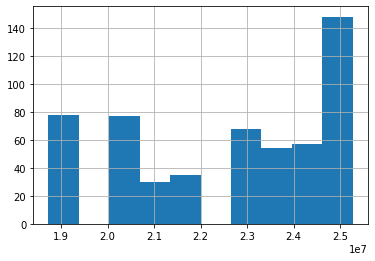

In [ ]:
df_prep[df_prep.tag!=0].PMID.hist()

In [ ]:
nb = df_prep.PMID.nunique()
nb

19

In [ ]:
df_prep.to_csv(join(PROCESSED_DATA_DIR, f'words_and_coords_{nb}_pdfs_labeled.csv'), sep=';', index=False)

#### &emsp;&emsp;4.1.2 Text preprocessing <a name="text_preprocessing"></a>

In [ ]:
nb = 19
df_m = pd.read_csv(join(PROCESSED_DATA_DIR, f'words_and_coords_{nb}_pdfs_labeled.csv'), sep=';')

In [ ]:
NUM_CLASSES = len(LABELS) + 1

In [ ]:
df_m.tag = df_m.tag.map({idx:tag for tag,idx in LABELS.items()})

In [20]:
df_m.iloc[[376, 377, 378, 379, 147850]]

x       y      w     h  ... page       PMCID      PMID         tag
376      278.0  1752.0  118.0  22.0  ...    0  PMC2516932  18725973        NONE
377      407.0  1752.0  149.0  28.0  ...    0  PMC2516932  18725973      AUTHOR
378      565.0  1753.0   39.0  24.0  ...    0  PMC2516932  18725973        NONE
379      616.0  1753.0   94.0  27.0  ...    0  PMC2516932  18725973      AUTHOR
147850  1681.0  1182.0  135.0  24.0  ...    9  PMC4196225  25271284  MICROBIOTA

[5 rows x 10 columns]

In [21]:
# More text preprocessing

df_m.text = df_m.text.astype(str)
# Remove leading and trailing spaces
df_m.text = df_m.text.str.strip()
# Drop if no word
df_m = df_m[df_m.text!='']

In [22]:
# Create sequences of window words

window = 5
df_m['sequence'] = ''
df_m['label'] = ''
for shift in range(window):
    df_m['sequence'] = df_m["text"].shift(shift) + ' ' + df_m['sequence']
    df_m['label'] = df_m["tag"].shift(shift) + ' ' + df_m['label']

In [23]:
# Undersample majority class

df_m2 = df_m.iloc[window:]
nb_not_none = df_m2[df_m2.tag!='NONE'].shape[0]
df_m2 = pd.concat([df_m2[(df_m2.tag=='NONE')].sample(nb_not_none), df_m2[(df_m2.tag!='NONE')]], 
                  ignore_index=True)


In [24]:
# Tokenize the sequence because we are predicting the label of the words
df_m2['token'] = df_m2.sequence.progress_apply(lambda x: str(x).split())
df_m2['label_token'] = df_m2.label.progress_apply(lambda x: str(x).split())

100%|██████████| 1094/1094 [00:00<00:00, 167716.97it/s]


In [25]:
# Train test split
df_train, df_test, y_train, y_test = train_test_split(df_m2, df_m2['label'],test_size=0.67,random_state=42)

In [26]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

In [27]:
# Construct an array containing every sequence-label that will be used for training
training_data = df_train[["token","label_token"]].values

# Just in cas do it also for the test dataset and the global dataset
data = df_m2[["token","label_token"]].values
test_data = df_test[["token","label_token"]].values

In [28]:
training_data

array([[list(['and', 'these', 'amounts', 'were', 'used']),
        list(['NONE', 'NONE', 'NONE', 'NONE', 'NONE'])],
       [list(['one', 'week', 'before', 'diagnosis', 'whereas']),
        list(['NONE', 'NONE', 'NONE', 'NONE', 'NONE'])],
       [list(['2.', 'Cluster', 'dendrogram', 'generated', 'using']),
        list(['NONE', 'NONE', 'NONE', 'NONE', 'NONE'])],
       [list(['samples', 'using', 'the', 'Wizard', 'Genomics']),
        list(['NONE', 'NONE', 'NONE', 'NONE', 'NONE'])],
       [list(['2', '_Parasutterella', '(OTU26)', '|', 'Ruminococcaceae']),
        list(['NONE', 'NONE', 'NONE', 'NONE', 'MICROBIOTA'])],
       [list(['HLA-B27', 'transgenic', 'rats', 'selectively', 'colonized']),
        list(['NONE', 'NONE', 'NONE', 'NONE', 'NONE'])],
       [list(['<0.0001)', 'and', 'significantly', 'more', 'Proteobacteria']),
        list(['NONE', 'NONE', 'NONE', 'NONE', 'MICROBIOTA'])],
       [list(['majority', 'of', 'the', 'elevated', 'Proteobacteria']),
        list(['NONE', 'NONE', 

In [29]:
# Define vocabulary
vocab_to_ix = {}
# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in data:
    for word in sent:
        if word not in vocab_to_ix:  # word has not been assigned an index yet
            vocab_to_ix[word] = len(vocab_to_ix)  # Assign each word with a unique index
print("Vocab to idx:", vocab_to_ix)

Vocab to idx: {'using': 0, 'multi-barcode': 1, '16S': 2, 'rRNA': 3, 'sequencing': 4, 'broader': 5, 'community.': 6, 'We': 7, 'used': 8, 'clinical': 9, 'molecular': 10, 'techniques.': 11, 'Proceedings': 12, 'of': 13, 'the': 14, 'found': 15, 'no': 16, 'significant': 17, 'differences': 18, 'years': 19, 'treated': 20, '(n=13)': 21, 'Comparison': 22, 'tvalue': 23, 'large': 24, 'box)': 25, 'and': 26, 'sp': 27, '(‘whiskers’': 28, 'Curr': 29, 'Issues': 30, 'Mol': 31, 'Biol': 32, '12:': 33, 'at': 34, 'time': 35, 'sample': 36, 'DB,': 37, 'Romero': 38, 'R,': 39, 'Amogan': 40, 'HP,': 41, 'T2DM.': 42, 'NGT=normal': 43, 'glucose': 44, 'tolerance;': 45, 'OTU': 46, '0.81': 47, '2508': 48, '0.0009765': 49, '0.36': 50, '0.70': 51, 'baseline': 52, 'levels': 53, '(data': 54, 'not': 55, 'shown).': 56, 'for': 57, '16': 58, 'hours,': 59, 'Table': 60, '9.': 61, 'generally': 62, 'contained': 63, 'an': 64, 'increased': 65, 'total': 66, 'al.': 67, '(2010)': 68, 'Molecular': 69, 'characterisation': 70, 'most': 71

In [30]:
prepare_sequence(training_data[0][0], to_ix=vocab_to_ix)

tensor([26, 75, 76, 77,  8])

### &emsp; 4.2 A recurrent network: LSTM <a name="lstm"></a>

In [31]:
## This cell contains all the tools that we constructed for this model and 
## that we put in functions to reuse it with the CNN model

## Parameters
LABELS
ID_LABELS = {value:key for key,value in LABELS.items()}

## Train functions
def train(model, data, vocab, loss_fun, optimizer, labels=LABELS, epochs= 20):
    for epoch in tqdm(range(epochs)):
        for sentence, tags in data:
            # Clear gradients out before each instance because Pytorch accumulates them
            model.zero_grad()

            # Turn data into Tensors of word indices
            sentence_in = prepare_sequence(sentence, vocab)
            targets = prepare_sequence(tags, labels)

            # Run forward pass
            tag_scores = model(sentence_in)

            # Compute the loss, gradients, and update the parameters
            loss = loss_fun(tag_scores, targets)
            loss.backward()
            optimizer.step()
    return model

## Inference functions
def pred_conf(seq, model, vocab, n_digits=5):
    """Computes the prediction of the model along with the confidence level, you can tune n_digits 
    if you want to reduce the number of digits of the confidence levels"""
    tag_scores = model(prepare_sequence(seq, vocab)) 
    
    max_tens = tag_scores.max(dim=1)
    argmaxs = max_tens.indices.tolist()
    maxs = max_tens.values.tolist()
    if n_digits:
        maxs = [round((arr * 10**n_digits)) / (10**n_digits) for arr in maxs] 
    
    return [argmaxs, maxs]

def pred_tag(tag_lis, id2label_lis):
    """Gives the predicted label from a sequence of prediction (simply takes the last element and 
    map the tag to the label)"""
    return id2label_lis[tag_lis[-1]]

def plot_confusion(classes, y_test, y_pred, figsize=(7,5)):    
    """Plots the confusion matrix given the prediction y_pred and the true labels y_test"""
    # Compute the matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
    
    # Rotate xticks for lisibility
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    
    return None

def get_pred(df2pred, model, vocab, labels:dict):
    """
    Takes:
        - df2pred: dataframe containing a variable 'token' that corresponds to the sequence tokenized
        - model: pytorch model for our NLP task
        - vocab: dictionnary of the vocabulary or the model
        - labels: dictionnary of the labels with their id
    """
    id2labels = {value:key for key,value in labels.items()}
    
    # Compute prediction
    df_pred = df2pred.token.apply(lambda seq: pd.Series(pred_conf(seq, model, 
                                                                  vocab_to_ix,
                                                                  n_digits=None),
                                                        index=["pred_label", "pred_label_conf"]))

    # Add prediction to the test dataframe
    df2pred['pred_label_cnn'] = df_pred['pred_label']
    df2pred["pred_tag_cnn"] = df_pred.pred_label.apply(pred_tag, id2label_lis=id2labels)

    # Compute confidence levels
    df2pred['pred_label_cnn_conf'] = df_pred['pred_label_conf']
    df2pred["pred_tag_cnn_conf"] = df_pred.pred_label_conf.apply(lambda x: x[-1])
    
    # Map predictions to their id
    y_test = df_test.tag.map(labels).tolist()
    y_pred = df_test.pred_tag_cnn.map(labels).tolist()
    
    return df2pred, y_test, y_pred

In [35]:
class LSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Word embedding
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # LSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # Linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores
    

In [36]:
EMBEDDING_DIM = 32
HIDDEN_DIM = 128
lstm = LSTM(EMBEDDING_DIM, HIDDEN_DIM, len(vocab_to_ix), len(LABELS))
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(lstm.parameters(), lr=0.1)

In [37]:
# lstm = train(model, training_data, vocab_to_ix, labels=LABELS, epochs= 20)
lstm = train(model=lstm, data=training_data, vocab=vocab_to_ix, loss_fun=loss_function,
                optimizer=optimizer, labels=LABELS, epochs= 20)

100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


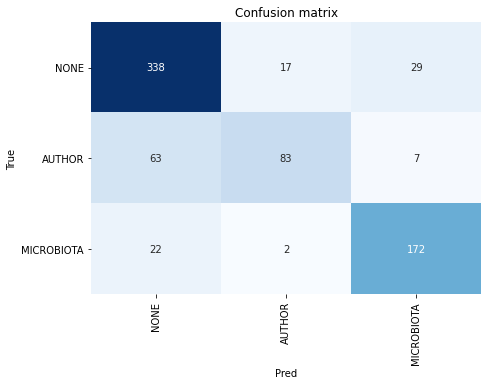

In [38]:
df_test, y_test, y_pred = get_pred(df2pred=df_test, model=lstm, vocab=vocab_to_ix, labels=LABELS)
plot_confusion(classes=LABELS.keys(), y_test=y_test, y_pred=y_pred, figsize=(7,5))

In [39]:
# Plot standard classification metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       384
           1       0.81      0.54      0.65       153
           2       0.83      0.88      0.85       196

    accuracy                           0.81       733
   macro avg       0.81      0.77      0.78       733
weighted avg       0.81      0.81      0.80       733



### &emsp; 4.2 A convolutionnal network <a name="cnn"></a>

In [40]:
class CNN(nn.Module):

    def __init__(self, tagset_size=len(LABELS), vocab_size=len(vocab_to_ix), embedding_dim=32, fc_dim=32):
        super().__init__()
        
        # Attributes parameters
        self.tagset_size = tagset_size
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.fc_dim = fc_dim
        self.tagset_size = tagset_size
        conv_input_dim = 2*self.embedding_dim 
        
        # Layers
        self.word_embeddings = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.conv = nn.Conv1d(in_channels=conv_input_dim, out_channels=fc_dim, kernel_size=1, bias=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(self.fc_dim, tagset_size)

    def forward(self, x):
        # Embedding
        x = x.unsqueeze(1)
        x = self.word_embeddings(x)
        x = torch.cat([x, x], dim=2)
        x = x.transpose(1,2)
        
        # Convolution + Relu
        x = self.conv(x)
        x = self.relu(x)
        
        # Fully connected
        x = x.transpose(1, 2)
        x = self.fc(x).squeeze(1)
        tag_scores = F.log_softmax(x, dim=1)
        
        return x

In [41]:
cnn = CNN()

In [42]:
loss_function = nn.CrossEntropyLoss() #because NLLLoss didn't work
optimizer = optim.SGD(cnn.parameters(), lr=0.1)

In [43]:
# Train the model
cnn = train(model=cnn, data=training_data, vocab=vocab_to_ix, loss_fun=loss_function,
                optimizer=optimizer, labels=LABELS, epochs= 20)

100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


In [44]:
df_test, y_test, y_pred = get_pred(df2pred=df_test, model=cnn, vocab=vocab_to_ix, labels=LABELS)

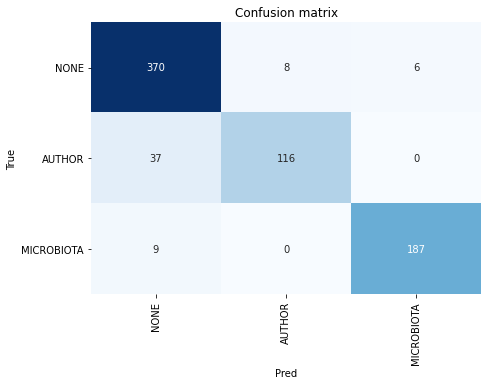

In [45]:
plot_confusion(classes=LABELS.keys(), y_test=y_test, y_pred=y_pred, figsize=(7,5))

In [46]:
# Plot standard classification metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       384
           1       0.94      0.76      0.84       153
           2       0.97      0.95      0.96       196

    accuracy                           0.92       733
   macro avg       0.93      0.89      0.91       733
weighted avg       0.92      0.92      0.92       733



## 5 [Conclusion](#conclusion)

We have tried to resolve a concrete business problem from end to end while using this use case as a pretext to meet the requirements of this project.

Here are the main limits that we identified, along with the improvements we suggest to face with these limits:
- **Reduce overfitting**: some microbiota have many occurences in one article, and our train-test split doesn't concentrate all occurences of an article in the same set. In order to evaluate the performance of the inference, no sequence of an article that participates to the training should be included in the test. Also we could add dropout layers to reduce overfitting.
- **Impacts of undersampling**: to train our models, we undersampled the 'NONE' class, which is by far the most majoritary one. Then, we didn't evaluate the performance of the model on 

# References quoted in this notebook
- [1] <a name="tess_overview"></a> R. Smith, "An Overview of the Tesseract OCR Engine", Ninth International Conference on Document Analysis and Recognition (ICDAR 2007), 2007, pp. 629-633, doi: 10.1109/ICDAR.2007.4376991.
- [2] <a name="db_for_microbio"></a> Igor B. Zhulin, "Databases for Microbiologists", Journal of Bacteriology Jul 2015, 197 (15) 2458-2467; doi: 10.1128/JB.00330-15
- [3] <a name="gmd_paper"></a> Liang Cheng, Changlu Qi, He Zhuang, Tongze Fu, Xue Zhang, "gutMDisorder: a comprehensive database for dysbiosis of the gut microbiota in disorders and interventions", Nucleic Acids Research, Volume 48, Issue D1, 08 January 2020, Pages D554–D560, https://doi.org/10.1093/nar/gkz843